In [0]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data = pd.read_csv(root_path+'preprocessed.csv')

In [0]:
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,ask native americans take be,1,0,0,0,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drink maga trump2020,3,2,1,1,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN


In [0]:
data.drop(columns = ['subtask_b' , 'subtask_c'] , inplace = True)

# Splitting Data: Train and Test


In [0]:
Y = data['subtask_a']
X = data.drop(['subtask_a','id'],axis=1)
print("Shape of X: ",X.shape)
print("Shape of Y: ",Y.shape)


Shape of X:  (13240, 6)
Shape of Y:  (13240,)


In [0]:
data['subtask_a'].value_counts()

NOT    8840
OFF    4400
Name: subtask_a, dtype: int64

#### Observation: 
We see that the dataset is clearly imbalanced with NOT OFFENSIVE tweets being the majority class.


In [0]:
#separating data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y,random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (9268, 6)
Shape of Y_train:  (9268,)
Shape of X_test:  (3972, 6)
Shape of Y_test:  (3972,)


#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(OFF=1, NOT=0))
Y_test = Y_test.map(dict(OFF=1, NOT=0))

# Making Data Model Ready: Encoding Tweets

## 1. Bag of Words : Tweets


In [0]:
vectorizer_tweet_bow = CountVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_bow.fit(X_train['new_tweet'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
X_train_tweet_bow = vectorizer_tweet_bow.transform(X_train['new_tweet'])
X_test_tweet_bow = vectorizer_tweet_bow.transform(X_test['new_tweet'])

print("Shape of X_train_tweet_bow ",X_train_tweet_bow.shape)
print("Shape of X_test_tweet_bow ",X_test_tweet_bow.shape)

Shape of X_train_tweet_bow  (9268, 3738)
Shape of X_test_tweet_bow  (3972, 3738)


##2. TF-IDF : Tweets

In [0]:
vectorizer_tweet_tfidf = TfidfVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_tfidf.fit(X_train['new_tweet'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
X_train_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_train['new_tweet'])
X_test_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_test['new_tweet'])

print("Shape of X_train_tweet_tfidf ",X_train_tweet_tfidf.shape)
print("Shape of X_test_tweet_tfidf ",X_test_tweet_tfidf.shape)

Shape of X_train_tweet_tfidf  (9268, 3738)
Shape of X_test_tweet_tfidf  (3972, 3738)


##3. Avg W2Vec : Tweets

In [0]:
# average Word2Vec
from scipy.sparse import csr_matrix  ## to make data type consistency across all methods


def get_avg_w2v(corpus):
    with open(root_path+'glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

    avg_w2v_vectors=[]
    for sentence in tqdm(corpus): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return csr_matrix(avg_w2v_vectors)

In [0]:
X_train_tweet_avg_w2v_vectors = get_avg_w2v(X_train['new_tweet'])
X_test_tweet_avg_w2v_vectors = get_avg_w2v(X_test['new_tweet'])

100%|██████████| 3972/3972 [00:00<00:00, 35912.82it/s]


In [0]:
# print("Shape of X_train_tweet_avg_w2v_vectors",len(X_train_tweet_avg_w2v_vectors),len(X_train_tweet_avg_w2v_vectors[0]))
# print("Shape of X_test_tweet_avg_w2v_vectors ",len(X_test_tweet_avg_w2v_vectors),len(X_test_tweet_avg_w2v_vectors[0]))
print("Shape of X_train_tweet_avg_w2v_vectors",X_train_tweet_avg_w2v_vectors.shape )
print("Shape of X_test_tweet_avg_w2v_vectors ",X_test_tweet_avg_w2v_vectors.shape )

Shape of X_train_tweet_avg_w2v_vectors (9268, 300)
Shape of X_test_tweet_avg_w2v_vectors  (3972, 300)


# Applying SVM on different featurization of Tweets

## 1. BOW



In [0]:
f1 = X_train_tweet_bow
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)
X_train_bow_svm =hstack((f1,f2,f3,f4))

# X_train_bow_svm =hstack((f1,f2,f3,f4,f5))
# pca = TruncatedSVD(n_components=100)

# reduced_train_bow_svm = pca.fit_transform(X_train_bow_svm)

In [0]:
f1 = X_test_tweet_bow
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)
X_test_bow_svm =hstack((f1,f2,f3,f4))

# X_test_bow_svm =hstack((f1,f2,f3,f4,f5))

# pca = TruncatedSVD(n_components=100)
# reduced_test_bow_svm = pca.fit_transform(X_test_bow_svm)


## Hyper Parameter Tuning: Lambda (SVC)


In [0]:
from sklearn.svm import SVC
# tune_parameters = [{'C': [10**-1,10 ** 0 , 10**1,10 **2] ,'loss':['hinge','squared_hinge']}]
tune_parameters = [{'C': [10**-1,10 ** 0 , 10**1,10 **2]}]

#Using GridSearchCV/
model = GridSearchCV(SVC(kernel='linear'), tune_parameters,scoring = 'roc_auc', return_train_score=True,n_jobs=-1, verbose=True, refit=True)
model.fit(X_train_bow_svm, Y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [0]:
# results = pd.DataFrame.from_dict(model.cv_results_)
# results = results.sort_values(['param_alpha'])

# train_auc= results['mean_train_score']
# train_auc_std= results['std_train_score']
# cv_auc = results['mean_test_score'] 
# cv_auc_std= results['std_test_score']
# param_alpha =  results['param_alpha']

# log_alpha = [(np.log(x)/np.log(10)) for x in param_alpha]

# plt.plot(log_alpha, train_auc, label='Train AUC')

# plt.plot(log_alpha, cv_auc, label='CV AUC')

# plt.scatter(log_alpha, train_auc, label='Train AUC points')
# plt.scatter(log_alpha, cv_auc, label='CV AUC points')


# plt.legend()
# plt.xlabel("Log base 10 of alpha: hyperparameter")
# plt.ylabel("AUC")
# plt.title("Hyper parameter Vs AUC plot")
# plt.grid()
# plt.show()

# results.head()

In [0]:
model.best_estimator_

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

**Obervations:**

1. We can see both from the graph as well as from the API response that the best value of C = 1

2. This can be seen as value of 1 on the x-axis of the error vs logC plot.

In [0]:
lr_bow = SVC()
lr_bow.fit(X_train_bow_svm,Y_train)

y_train_pred = lr_bow.predict_proba(X_train_bow_svm)
y_test_pred = lr_bow.predict_proba(X_test_bow_svm)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train.values, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test.values, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

AttributeError: ignored

## Results - Confusion Matrix

In [0]:
# svm_bow = LinearSVC()
svm_bow = SVC(kernel='linear',C=0.5,class_weight='balanced')

svm_bow.fit(X_train_bow_svm,Y_train)

SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

F1 Score = 0.700901216625265


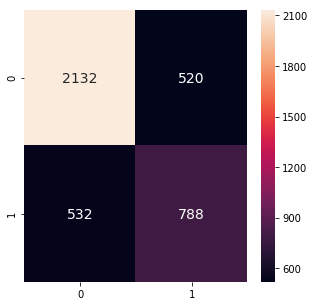

In [0]:
y_test_predict = svm_bow.predict(X_test_bow_svm)

results = confusion_matrix(Y_test, y_test_predict)
plt.figure(figsize = (5,5))
sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')

print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average= 'macro')))
#old f1 0.7092119070210772

### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

1052 misclassifications


In [0]:
def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk)) 

Red: original not offensive (0), classified as offensive (1) <br>
Green: original offensive (1), classified as not offensive (0)

In [0]:
#OFF=1, NOT=0)
for index in misclassified[0]:
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prGreen(X_test.iloc[index,0])

 @USER @USER Yeah. He’s very immature &amp; can dish out criticism while crying and blocking instead of accepting any. It’s cool. Folks can see him for who he is mostly.
 @USER @USER @USER @USER @USER needs to take action instead of turning a blind eye to what occurred. It was shameful behaviour, tantamount to organised bullying. Reprehensible" just a word. If she ignores it. she is part of problem. Ineffective leadership entrenches this rot in ALP party culture"
 @USER @USER @USER Why shouldn’t we be surprised when someone who promotes ANTIFA violence in public is suddenly accused of violence/domestic violence etc?!!?
 @USER Awful
 @USER You sound like the Nazis my family came to America to go back and fight in their home. You have a lot to learn. Antifa is an Enemy of America just like the Nazi's
 @USER @USER agreed fuck that guy
 @USER Liberals that think the world owes them a living.
 @USER I have found that my younger women doctors don't ignore me when I say I know my body, and ar

## 2. TF-IDF


In [0]:
f1 = X_train_tweet_tfidf
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)

# print(type(f1))
X_train_tfidf =hstack((f1,f2,f3,f4, f5))
X_train_tfidf.shape

(9268, 3742)

In [0]:
f1 = X_test_tweet_tfidf
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

X_test_tfidf =hstack((f1,f2,f3,f4,f5))
X_test_tfidf.shape

(3972, 3742)

## Hyperparameter Tuning

In [0]:
tune_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(SVC(class_weight='balanced'), tune_parameters, scoring = 'roc_auc', cv=10, return_train_score=True,n_jobs=-1, verbose=True)
model.fit(X_train_tfidf, Y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

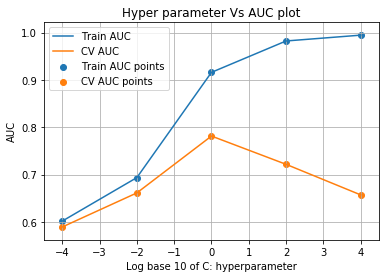

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.023215,0.001299,0.002804,0.000287,0.0001,{'C': 0.0001},0.607282,0.600004,0.591796,0.593217,0.592907,0.577634,0.550511,0.555898,0.598727,0.626337,0.589426,0.021654,5,0.600462,0.601532,0.600432,0.601601,0.601414,0.603680,0.605536,0.605273,0.601108,0.597517,0.601856,0.002286
1,0.039514,0.003538,0.002857,0.000233,0.01,{'C': 0.01},0.674189,0.676080,0.667473,0.683098,0.664876,0.661341,0.614087,0.616547,0.656911,0.699342,0.661391,0.025707,3,0.696446,0.691092,0.691954,0.692734,0.696383,0.696115,0.693218,0.695958,0.689925,0.693880,0.693770,0.002257
2,0.062780,0.005177,0.002927,0.000140,1,{'C': 1},0.777886,0.778974,0.798229,0.791442,0.769407,0.758424,0.782022,0.776572,0.778680,0.803501,0.781512,0.012622,1,0.916710,0.916482,0.915587,0.916172,0.916912,0.917949,0.915707,0.915983,0.914429,0.915247,0.916118,0.000925
3,0.226092,0.014693,0.002939,0.000094,100,{'C': 100},0.713654,0.716400,0.741372,0.726287,0.720816,0.706817,0.720223,0.716636,0.723569,0.732025,0.721778,0.009279,2,0.982614,0.981545,0.982284,0.982741,0.983596,0.982568,0.982883,0.982270,0.981895,0.981759,0.982415,0.000573
4,1.477904,0.371929,0.002852,0.000182,10000,{'C': 10000},0.651782,0.642742,0.681079,0.633531,0.656783,0.668941,0.685684,0.655813,0.630811,0.664978,0.657216,0.017541,4,0.994281,0.996352,0.991555,0.996977,0.997407,0.992022,0.991776,0.994966,0.996529,0.995211,0.994708,0.002114


In [0]:
results = pd.DataFrame.from_dict(model.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
param_C =  results['param_C']

log_C = [(np.log(x)/np.log(10)) for x in param_C]

plt.plot(log_C, train_auc, label='Train AUC')

plt.plot(log_C, cv_auc, label='CV AUC')

plt.scatter(log_C, train_auc, label='Train AUC points')
plt.scatter(log_C, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log base 10 of C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [0]:
model.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

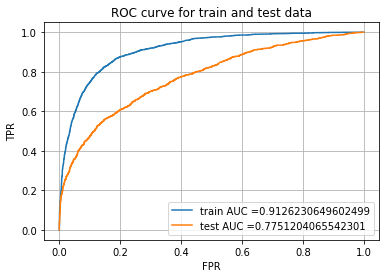

In [0]:
lr_tfidf = model.best_estimator_
lr_tfidf.fit(X_train_tfidf,Y_train)

y_train_pred = lr_tfidf.predict_proba(X_train_tfidf)
y_test_pred = lr_tfidf.predict_proba(X_test_tfidf)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

## Result - Confusion Matrix

F1 Score = 0.702118019325863


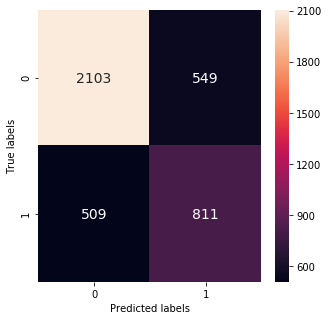

In [0]:
svm_tfidf = SVC(kernel='linear',C=0.5,class_weight='balanced')
svm_tfidf.fit(X_train_tfidf,Y_train)

y_test_predict = svm_tfidf.predict(X_test_tfidf)

results = confusion_matrix(Y_test, y_test_predict)

plt.figure(figsize = (5,5))
ax = sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 


print("F1 Score = " + str(f1_score(Y_test,y_test_predict, average='macro')))
#old F1 Score = 0.6990306485691533


### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

1112 misclassifications


Red: original not offensive (0), classified as offensive (1) <br>
Green: original offensive (1), classified as not offensive (0)

In [0]:
#OFF=1, NOT=0)
for index in misclassified[0]:
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prGreen(X_test.iloc[index,0])

 @USER @USER @USER No he didn't. He said I'm sure there is fine people on both sides. Do you disagree with that or are you one of those far left people who think all conservatives are racists. Antifa is a terror group that uses violence against innocent people who think differently.
 @USER @USER Let's see how many planes are turned around or crazy airport shut downs happen over next few days. Maybe a drinking game? @USER  #WWG1WGA  #MAGA
 All this talk about Trump's dick allegedly looking like Toad from #MarioKart  This is the only thing that has been accomplished. Only now the libs are picturing a 70 year old man naked.   #MAGA URL
 @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER Charts by David Webster's briefings on benefit sanctions   (Nov 2013 to Sept 2018) URL
 @USER Bill you should be silent on gun control and immigrantion.   You had 8 years and did nothing. Don't be a Monday morning quarterback now. To little to late.


# 3. AvgW2Vec 

In [0]:
f1 = X_train_tweet_avg_w2v_vectors

f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)

X_train_w2vec =hstack((f1,f2,f3,f4,f5))
X_train_w2vec.shape


(9268, 304)

In [0]:

f1 = X_test_tweet_avg_w2v_vectors
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

X_test_w2vec =hstack((f1,f2,f3,f4,f5))
X_test_w2vec.shape


(3972, 304)

## Hyper parameter tuning (LinearSVC)

In [0]:
tune_parameters = [{'C': [10**-2, 10**-1, 10**0, 10**1, 10**2]}]

#Using GridSearchCV
model = GridSearchCV(LinearSVC(class_weight='balanced'), tune_parameters, scoring = 'roc_auc', cv=10, return_train_score=True,n_jobs=-1, verbose=True)
model.fit(X_train_w2vec, Y_train)

In [0]:
results = pd.DataFrame.from_dict(model.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
param_C =  results['param_C']

log_C = [(np.log(x)/np.log(10)) for x in param_C]

plt.plot(log_C, train_auc, label='Train AUC')

plt.plot(log_C, cv_auc, label='CV AUC')

plt.scatter(log_C, train_auc, label='Train AUC points')
plt.scatter(log_C, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log base 10 of C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [0]:
model.best_estimator_

In [0]:
lr_w2vec = model.best_estimator_
lr_w2vec.fit(X_train_w2vec,Y_train)

y_train_pred = lr_w2vec.predict_proba(X_train_w2vec)
y_test_pred = lr_w2vec.predict_proba(X_test_w2vec)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

## Result - Confusion Matrix 

F1 Score = 0.6430543817888446


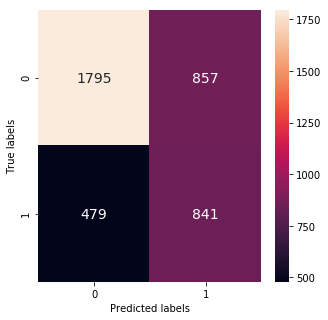

In [0]:
svm_w2vec = LinearSVC(class_weight='balanced')

svm_w2vec.fit(X_train_w2vec,Y_train)

y_test_predict = svm_w2vec.predict(X_test_w2vec)

results = confusion_matrix(Y_test, y_test_predict)

plt.figure(figsize = (5,5))
ax = sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 


print("F1 Score = " + str(f1_score(Y_test,y_test_predict, average='macro')))

### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

1254 misclassifications


Red: original not offensive (0), classified as offensive (1) <br>
Green: original offensive (1), classified as not offensive (0)

In [0]:
#OFF=1, NOT=0)
for index in misclassified[0]:
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prGreen(X_test.iloc[index,0])

 @USER Copycat
 @USER @USER Let's see how many planes are turned around or crazy airport shut downs happen over next few days. Maybe a drinking game? @USER  #WWG1WGA  #MAGA
 @USER @USER Somebody do something!!! This show sucks anymore!! The set designers are good though! #firemalyoung
 @USER @USER Apparently Twitter didn’t like your Ellison post. Screen capped anyways and will post elsewhere.. #MAGA
 @USER Bill you should be silent on gun control and immigrantion.   You had 8 years and did nothing. Don't be a Monday morning quarterback now. To little to late.
 @USER I suppose you think the way liberals attacked Sarah Palin was courageous also. You’re just another hypocrite.
 @USER Good! #Antifa is violent fascism.
 2. This lady nails it ⬇️ “Brexit seems to have unleashed an angry incivility”. Unless moderate #OneNation @USER stand up &amp; fight for a sensible moderate Brexit (for me that’s EFTA @USER we risk becoming a #HardBrexit party rejected by moderates &amp; replaced by Corbyn U